## CSC420 Assignment 5
### Brendan Neal | 1001160236 | nealbre1

Imports and some helper functions

In [1]:
import numpy as np
from scipy import spatial, cluster
import cv2 as cv
import math
import re
import os
import tensorflow as tf
import keras
from collections import Counter

from matplotlib import pyplot as plot

# Tensorflow GPU usage configuration, allocate on-the-fly instead of pre-emptive
# https://stackoverflow.com/questions/36927607/how-can-i-solve-ran-out-of-gpu-memory-in-tensorflow
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Seed RNG for consistency
np.random.seed(420)

# Make the plot a certain size
plot.rcParams["figure.figsize"] = [8, 6]


def display_image(img, file_name=None, save_norm=True, save_type=np.uint8):
    """
    Shows an image (max-min normalized to 0-255), and saves it if a filename is given 
    save_norm = whether to save the normalized image
    save_type = what datatype to save the image as
    """
    
    flt_img = img.astype(float)
    img_max, img_min = np.max(flt_img), np.min(flt_img)
    norm = (((flt_img - img_min) / (img_max - img_min)) * 255).astype(np.uint8)
    
    if len(img.shape) == 2:
        plot.imshow(norm, cmap='gray')  
    elif (len(img.shape) == 3):
        plot.imshow(cv.cvtColor(norm, cv.COLOR_BGR2RGB))
    plot.show()
    
    to_save = norm if save_norm else flt_img
    if file_name:
        cv.imwrite(file_name, to_save)

Using TensorFlow backend.


### Question 2: Deep Learning

#### Question 2a: Vanishing Gradient

The vanishing gradient problem occurs when trying to optimize neural networks using gradient descent. During gradient descent, a weight $w$ will be incremented/decremented proportionally to $L_w$, which is the partial derivative of the loss function $L$ with respect to $w$. This partial derivative is therefore determined by the activation function that will eventually be applied to the product of the weight and some input.

Certain activation functions have very small gradients in certain regions. If a weight is updated according to these gradients, the update amount could be very small or even 0 if the numbers underflow. In other words, the gradient has "vanished". This problem means that a network's weights may update slowly or not at all during training. When layers of activation functions with vanishing gradients are stacked, this problem can be magnified by their repeated application. Weights towards the front (input) of the network will suffer the most from this, as activation functions will be applied to them the most.

#### Mitigating Solutions:

* Use activation functions that don't have regions of extremely low gradient. Caution: extremely high gradients lead to the oppositely named exploding gradient problem (large gradients produce large weight updates). Example: leaky rectifier function:

$$f(x) = \max\{| ax |, x\} : a \in [0, 1)$$
$$f'(x < 0) = a$$
$$f'(x > 0) = 1$$


* Skip connections. Say data flows through layers A, B, C. Some information from A may never reach C, so "skip connections" are used to pass information from A directly to C. This can overcome vanishing gradients caused by the application of B's activation function. However, this increases the number of computations that must be done at layer C as it now has to deal with two input sources A, B.


#### Question 2b: Purpose of Max Pooling

* Makes the CNN tolerate distortions in input images. Distortions/shifts will be effectively "smoothed over" if the highest-value feature is taken in a neighbourhood. 


* Reduces dimensionality (e.g. a 2x2 max-pooling layer will reduce image size to 1/4). This reduces the amount of computation that must be done to process the image further down the network, reducing the complexity of the network.

#### Question 2c: Loading Data

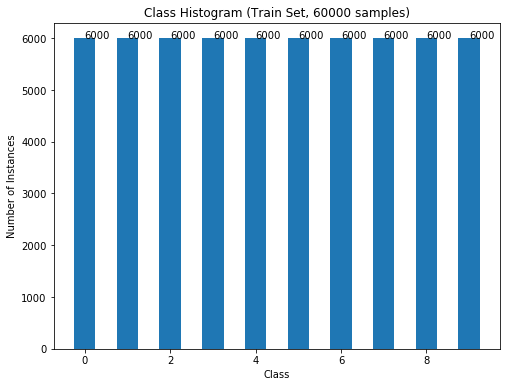

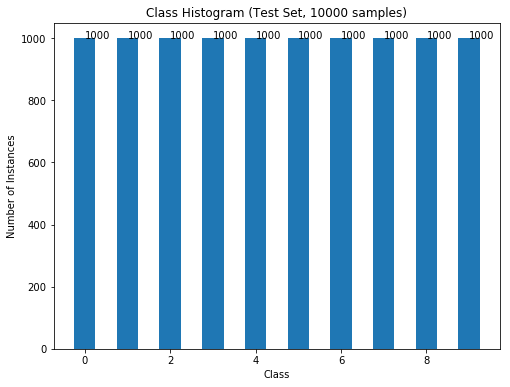

In [2]:
# Data is already split up into pre-determined train and test
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize x's (0-255  -> 0-1), add extra dimension to end
x_train = np.expand_dims((x_train.astype(np.float32) / 255), axis=-1)
x_test = np.expand_dims((x_test.astype(np.float32) / 255), axis=-1)

# Determine number of classes on-the-fly
all_y = np.concatenate((y_train, y_test))
NUM_CLASSES = len(np.unique(all_y))

# Helper function for plotting histogram
def class_histogram(classes, title, save_path):
    
    bins = list(range(NUM_CLASSES+1))
    
    arr = plot.hist(
        classes, 
        bins = bins,
        rwidth = 0.5, align = "left"
    )
    
    # Write counts over each bar
    # https://stackoverflow.com/questions/39841733/matplotlib-histogram-how-to-display-the-count-over-the-bar
    for i in range(NUM_CLASSES):
        plot.text(arr[1][i], 
                  arr[0][i],
                  str(int(arr[0][i])))
        
    plot.xlabel("Class")
    plot.ylabel("Number of Instances")
        
    plot.title(title)
    plot.savefig(save_path)
    plot.show()



# Plot histogram for train set
class_histogram(
    y_train, 
    title = "Class Histogram (Train Set, {} samples)".format(len(y_train)),
    save_path = "q2c-train-histogram.png"
)

# Plot histogram for test set
class_histogram(
    y_test, 
    title = "Class Histogram (Test Set, {} samples)".format(len(y_test)),
    save_path = "q2c-test-histogram.png"
)

# Turn y's into one-hot labels
y_train = np.eye(NUM_CLASSES)[y_train]
y_test = np.eye(NUM_CLASSES)[y_test]

#### Question 2d: Model


Using dropout layers to reduce overfitting. These are effectively pass-through layers that "zero-out" some units at random during training so the network doesn't become too reliant on a few powerful neurons' decisions.

In [3]:
# Defining hyper parameters first for modularity

# Input shape should be 1 image
assert (x_train.shape[1:] == x_test.shape[1:])
INPUT_SHAPE = x_train.shape[1:]

# First Layer (Convolutional)
NUM_UNITS_0 = 30
KERNEL_SIZE_0 = 3
POOL_SIZE_0 = 2
PADDING_0 = "valid"
ACTIVATION_0 = "relu"
DROPOUT_0 = 0.3

# Second Layer (Convolutional)
NUM_UNITS_1 = 20
KERNEL_SIZE_1 = 3
POOL_SIZE_1 = 2
PADDING_1 = "valid"
ACTIVATION_1 = "relu"
DROPOUT_1 = 0.3

# Third Layer (Flat)
NUM_UNITS_2 = 200
ACTIVATION_2 = "relu"
DROPOUT_2 = 0.5

# Fourth Layer / OUTPUT (Flat)
NUM_UNITS_3 = NUM_CLASSES
ACTIVATION_3 = "softmax" # For classification

# Build the network as stack (2 Conv, 2 Flat)
model = keras.Sequential()

# First Layer (Conv)
model.add(keras.layers.Conv2D(input_shape=INPUT_SHAPE,
                                 filters=NUM_UNITS_0, 
                                 kernel_size=KERNEL_SIZE_0,
                                 activation=ACTIVATION_0))
model.add(keras.layers.MaxPooling2D(pool_size=POOL_SIZE_0))
model.add(keras.layers.Dropout(DROPOUT_0))

# Second Layer (Conv)
model.add(keras.layers.Conv2D(filters=NUM_UNITS_1, 
                                 kernel_size=KERNEL_SIZE_1,
                                 activation=ACTIVATION_1))
model.add(keras.layers.MaxPooling2D(pool_size=POOL_SIZE_1))
model.add(keras.layers.Dropout(DROPOUT_1))

# Third Layer (Flat)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(NUM_UNITS_2, activation=ACTIVATION_2))
model.add(keras.layers.Dropout(DROPOUT_2))

# Fourth Layer (Flat) / OUTPUT
model.add(keras.layers.Dense(NUM_UNITS_3, activation=ACTIVATION_3))

#### Question 2e: Loss Function

Using categorical cross-entropy (CCE) loss:

$$
L_{CCE}(t, y) = 
-\frac{1}{N}
\sum_{i=1}^{N}
\sum_{k=1}^{D}
\left(
t_{k}^{(i)} \log{y_{k}^{(i)}} + 
(1 - t_{k}^{(i)}) \log{(1 - y_{k}^{(i)})} 
\right)
$$



$D$ - dimensionality of predictions / ground truth (one-hot*)

$N$ - number of samples

$t$ - all ground truth labels ($N$ total, each has $D$ elements)

$t^{(i)}$ - $i$-th ground-truth label

$y$ - all predictions ($N$ total, each has $D$ elements)

$y^{(i)}$ - $i$-th prediction

$x_k$ - $k$-th element of vector x 


Note: log refers to natural logarithm here

*One-Hot - method of encoding class labels. If $x$ is class $i$, then its ground truth $t_x[i] = 1$. The non $i$-th elements of $t_x$ are 0.


#### Question 2f: Training Loop

Training should stop when the model's training accuracy and it's validation accuracy begin to diverge. If the training accuracy is increasing while the validation accuracy is decreasing, the model is likely overfitting the training data.

It is assumed that both the training and validation data are drawn from the same distribution. Therefore, a model should perform roughly the same on either collection of data. If a model consistently performs better on the training data than the validation data, it has begun to overfit the training data. Training should stop before this occurs so as to produce a more generalizable (and therefore useful) model. Conversely, training should stop when the model's validation loss consistently exceeds its training loss (loss is opposite to accuracy).

Implementing training loop for purposes of assignment instead of Keras' builtin *model.fit()* method.

In [4]:
def reset_weights(model):
    """
    Resets weights of a Keras model. Source:
    https://www.codementor.io/nitinsurya/how-to-re-initialize-keras-model-weights-et41zre2g
    """
    session = keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

def shuffled_range(length):
    """
    Produces a shuffling of [0...length-1]
    """
    ret = np.arange(length)
    np.random.shuffle(ret)
    return ret

def test_model(model, x, y, batch_size=10000):
    """
    Combines the test results over several splits of x and y.
    Used to reduce one-time load on GPU at test time.
    """
    assert (x.shape[0] == y.shape[0])
    num_samples = x.shape[0]
    num_batches = max(num_samples // batch_size, 1)
    
    x_batches, y_batches = np.array_split(x, num_batches), np.array_split(y, num_batches)
    
    # Tuples of form (loss, accuracy, batch_size)
    acc_loss_weight = [
        (*model.test_on_batch(x_batch, y_batch), x_batch.shape[0])
        for x_batch, y_batch in zip(x_batches, y_batches)
    ]
    
    # Need to multiply by weight in case of unevenly divided batches
    loss = sum(tup[0] * tup[2] for tup in acc_loss_weight) / num_samples
    acc = sum(tup[1] * tup[2] for tup in acc_loss_weight) / num_samples
    
    return loss, acc
        

def train_model(model, train_x, train_y, valid_x, valid_y, batch_size, epochs):
    """
    Explicit training loop algorithm for academic grading. Slower than builtins.
    """
    
    # Make sure there's a label for every input
    assert (train_x.shape[0] == train_y.shape[0])
    assert (valid_x.shape[0] == valid_y.shape[0])
    
    # Determine how many batches per epoch we have to produce
    num_train = train_x.shape[0]
    num_batches = num_train // batch_size
    
    # Iterator over possible batchings 
    batchings = (
        np.array_split(shuffled_range(num_train), num_batches)
        for _ in range(num_batches)
    )
    
    # Accumulate history of performance
    history = []
    for _ in range(epochs):
        
        # Determine how to split data, then train model on batches
        batch_inds = np.array_split(shuffled_range(num_train), num_batches)
        for inds in batch_inds:
            model.train_on_batch(train_x[inds], train_y[inds])
            
        # Gather performance of model on training and validation
        train_loss, train_acc = test_model(model, train_x, train_y)
        valid_loss, valid_acc = test_model(model, valid_x, valid_y)
        
        history += [(train_loss, train_acc, valid_loss, valid_acc)]
    
    return history

def plot_model_history(history, loss_path, acc_path):
    
    epochs = list(range(len(history)))
    train_losses, train_accs, valid_losses, valid_accs = zip(*history)
    
    train_loss, = plot.plot(train_losses, label="Training Loss")
    valid_loss, = plot.plot(valid_losses, label="Validation Loss")
    plot.legend(handles=[train_loss, valid_loss])
    
    plot.title("Model Loss")
    plot.xlabel("Epoch")
    plot.ylabel("Loss @ End of Epoch")
    
    plot.savefig(loss_path)
    plot.show()
    
    train_acc, = plot.plot(epochs, train_accs, label="Training Accuracy")
    valid_acc, = plot.plot(epochs, valid_accs, label="Validation Accuracy")
    plot.legend(handles=[train_acc, valid_acc])
    
    plot.title("Model Accuracy")
    plot.xlabel("Epoch")
    plot.ylabel("Accuracy @ End of Epoch")
    
    plot.savefig(acc_path)
    plot.show()

Code to train the model with a batch size of 128 for 50 epochs to demonstrate the divergence of training and validation loss/accuracy. This divergance becomes relatively large around the 5th iteration and continues to grow.

Learning Rate: 0.001
Batch Size: 128

Model Architecture
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 30)        300       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 30)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 20)        5420      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 20)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)

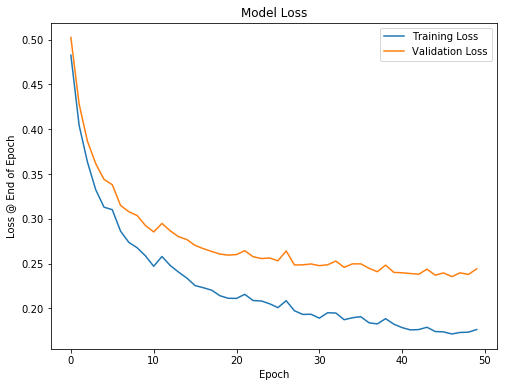

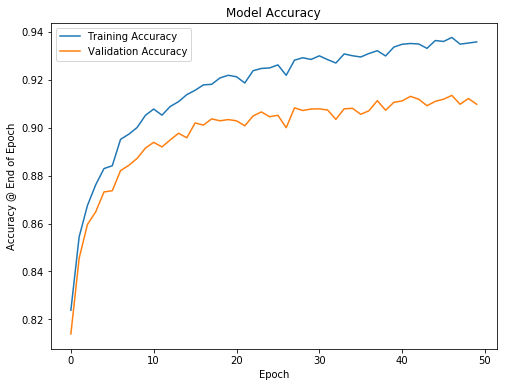

In [5]:
# Training Hyper Params
LOSS_FUNCTION = "categorical_crossentropy"
LEARNING_RATE = 0.001
OPTIMIZER = keras.optimizers.Adam(lr=LEARNING_RATE)
BATCH_SIZE = 128
NUM_EPOCHS = 50

# Compile the model
model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=["accuracy"])
reset_weights(model)

# Show various aspects of the model
print("Learning Rate: {}".format(LEARNING_RATE))
print("Batch Size: {}\n".format(BATCH_SIZE))

print("Model Architecture")
model.summary()
print("\n")

# Train the model
history = train_model(model, x_train, y_train, x_test, y_test, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS)
print("Epochs Trained: {}".format(NUM_EPOCHS))


# Evaluate the model for final accuracy
train_loss, train_acc = test_model(model, x_train, y_train)
print("Final Train Loss:     {}".format(train_loss))
print("Final Train Accuracy: {}".format(train_acc))

val_loss, val_acc = test_model(model, x_test, y_test)
print("Final Validation Loss:     {}".format(val_loss))
print("Final Validation Accuracy: {}".format(val_acc))

# Plot the model's history
plot_model_history(history, "q2f-loss.png", "q2f-accuracy.png")

#### Question 2g: Training with Multiple Batch Sizes

Batch Size: 64


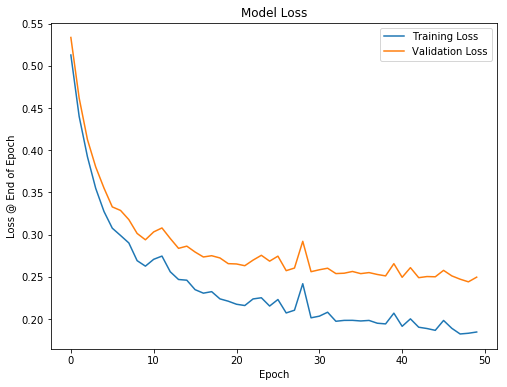

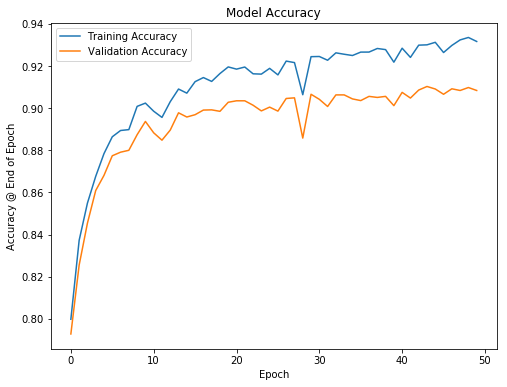

KeyboardInterrupt: 

In [7]:
for batch_size in [64, 32, 16, 8]:
    # Reset the model
    reset_weights(model)
    
    # Train the model again
    history = train_model(model, x_train, y_train, x_test, y_test, batch_size, epochs = 20)
    print("Batch Size: {}".format(batch_size))
    
    plot_model_history(history, 
                       "q2g-batch-{}-loss.png".format(batch_size), 
                       "q2g-batch-{}-accuracy.png".format(batch_size))